In [1]:
import re
import numpy as np
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time
import malaya

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
tokenizer = malaya.preprocessing._SocialTokenizer().tokenize
rules_normalizer = malaya.texts._tatabahasa.rules_normalizer

def is_number_regex(s):
    if re.match("^\d+?\.\d+?$", s) is None:
        return s.isdigit()
    return True

def detect_money(word):
    if word[:2] == 'rm' and is_number_regex(word[2:]):
        return True
    else:
        return False

def preprocessing(string):
    tokenized = tokenizer(unidecode(string))
    tokenized = [malaya.stem.naive(w) for w in tokenized]
    tokenized = [w.lower() for w in tokenized if len(w) > 1]
    tokenized = [rules_normalizer.get(w, w) for w in tokenized]
    tokenized = ['<NUM>' if is_number_regex(w) else w for w in tokenized]
    tokenized = ['<MONEY>' if detect_money(w) else w for w in tokenized]
    return tokenized

In [3]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen][::-1]):
            X[i, -1 - no] = dic.get(k, UNK)
    return X

In [4]:
preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya jd')

['raja',
 'benar',
 'sangat',
 'benci',
 'rakyat',
 'minyak',
 'naik',
 'gala',
 'jadi']

In [5]:
import json

with open('tokenization.json') as fopen:
    dataset = json.load(fopen)
texts = dataset['texts']
labels = dataset['labels']
del dataset

In [6]:
with open('subjectivity-dictionary.json') as fopen:
    d = json.load(fopen)
dictionary = d['dictionary']
rev_dictionary = d['reverse_dictionary']

In [7]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def Attention(inputs, num_units, num_heads = 8, activation = None):
    T_q = T_k = tf.shape(inputs)[1]
    Q_K_V = tf.layers.dense(inputs, 3*num_units, activation)
    Q, K, V = tf.split(Q_K_V, 3, -1)
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), 0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), 0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), 0)
    align = tf.matmul(Q_, K_, transpose_b=True)
    align *= tf.rsqrt(tf.to_float(K_.get_shape()[-1].value))
    paddings = tf.fill(tf.shape(align), float('-inf'))
    lower_tri = tf.ones([T_q, T_k])
    lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
    masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0],1,1])
    align = tf.where(tf.equal(masks, 0), paddings, align)
    align = tf.nn.softmax(align)
    alignments = tf.transpose(align, [0, 2, 1]) 
    x = tf.matmul(align, V_)
    x = tf.concat(tf.split(x, num_heads, axis=0), 2)
    x += inputs
    x = layer_norm(x)
    return x, alignments

class Model:
    def __init__(self, size_layer, embed_size, dict_size, dimension_output, learning_rate = 1e-3):
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        
        encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embed_size], -1, 1))
        x = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        x += position_encoding(x)
        x = tf.layers.dropout(x, 0.3, training=True) 
        
        x, self.alignments = Attention(x, size_layer)
        self.logits_seq = tf.layers.dense(x, dimension_output)
        self.logits_seq = tf.identity(self.logits_seq, name = 'logits_seq')
        self.logits = self.logits_seq[:,-1]
        self.logits = tf.identity(self.logits, name = 'logits')

        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.identity(tf.reduce_mean(self.alignments[0], 1), name = 'alphas')

In [8]:
size_layer = 256
dimension_output = 2
learning_rate = 1e-4
batch_size = 32
maxlen = 100

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    size_layer,
    len(dictionary),
    dimension_output,
    learning_rate,
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [9]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and '_power' not in n.name
    ]
)

In [10]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'dense/kernel',
 'dense/bias',
 'gamma',
 'beta',
 'dense_1/kernel',
 'dense_1/bias',
 'logits_seq',
 'logits',
 'alphas']

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(
    texts, labels, test_size = 0.2
)

In [12]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = str_idx(train_X[i : min(i + batch_size, len(train_X))], dictionary, maxlen)
        batch_y = train_Y[i : min(i + batch_size, len(train_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
        batch_y = test_Y[i : min(i + batch_size, len(test_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1

train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.58it/s, accuracy=0.5, cost=0.736]  

epoch: 0, pass acc: 0.000000, current acc: 0.523220
time taken: 5.806101560592651
epoch: 0, training loss: 0.817261, training acc: 0.514117, valid loss: 0.775383, valid acc: 0.523220



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.40it/s, accuracy=0.688, cost=0.533]

epoch: 1, pass acc: 0.523220, current acc: 0.644143
time taken: 5.657262086868286
epoch: 1, training loss: 0.677721, training acc: 0.592797, valid loss: 0.638242, valid acc: 0.644143



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.56it/s, accuracy=0.812, cost=0.443]

epoch: 2, pass acc: 0.644143, current acc: 0.682500
time taken: 5.664896726608276
epoch: 2, training loss: 0.575243, training acc: 0.702472, valid loss: 0.592246, valid acc: 0.682500



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.63it/s, accuracy=0.844, cost=0.459]

epoch: 3, pass acc: 0.682500, current acc: 0.710654
time taken: 5.649252414703369
epoch: 3, training loss: 0.542889, training acc: 0.728573, valid loss: 0.581850, valid acc: 0.710654



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.81it/s, accuracy=0.781, cost=0.359]

epoch: 4, pass acc: 0.710654, current acc: 0.715170
time taken: 5.652747392654419
epoch: 4, training loss: 0.516355, training acc: 0.751286, valid loss: 0.576073, valid acc: 0.715170



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.43it/s, accuracy=0.812, cost=0.361]

epoch: 5, pass acc: 0.715170, current acc: 0.736745
time taken: 5.6796722412109375
epoch: 5, training loss: 0.490288, training acc: 0.768352, valid loss: 0.545713, valid acc: 0.736745



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.91it/s, accuracy=0.906, cost=0.384]

time taken: 5.651562929153442
epoch: 6, training loss: 0.462611, training acc: 0.784666, valid loss: 0.555901, valid acc: 0.733456



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.93it/s, accuracy=0.875, cost=0.382]

epoch: 7, pass acc: 0.736745, current acc: 0.771422
time taken: 5.651054620742798
epoch: 7, training loss: 0.440179, training acc: 0.797214, valid loss: 0.517839, valid acc: 0.771422



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.18it/s, accuracy=0.938, cost=0.291]

time taken: 5.652914762496948
epoch: 8, training loss: 0.429743, training acc: 0.804367, valid loss: 0.526424, valid acc: 0.757875



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.36it/s, accuracy=0.906, cost=0.249]

epoch: 9, pass acc: 0.771422, current acc: 0.773652
time taken: 5.669234275817871
epoch: 9, training loss: 0.412455, training acc: 0.815284, valid loss: 0.496621, valid acc: 0.773652



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.58it/s, accuracy=0.844, cost=0.321]

time taken: 5.667682409286499
epoch: 10, training loss: 0.395102, training acc: 0.826453, valid loss: 0.512885, valid acc: 0.768913



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.61it/s, accuracy=0.844, cost=0.292]

epoch: 11, pass acc: 0.773652, current acc: 0.775436
time taken: 5.670521974563599
epoch: 11, training loss: 0.380442, training acc: 0.829213, valid loss: 0.503690, valid acc: 0.775436



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.15it/s, accuracy=0.875, cost=0.257]

time taken: 5.68050217628479
epoch: 12, training loss: 0.371508, training acc: 0.839880, valid loss: 0.516881, valid acc: 0.768412



train minibatch loop:   2%|▏         | 5/250 [00:00<00:05, 48.64it/s, accuracy=0.938, cost=0.205]

time taken: 5.675169944763184
epoch: 13, training loss: 0.361908, training acc: 0.843770, valid loss: 0.540839, valid acc: 0.760384



test minibatch loop: 100%|██████████| 63/63 [00:00<00:00, 127.41it/s, accuracy=0.667, cost=0.809]

time taken: 5.655407428741455
epoch: 14, training loss: 0.345508, training acc: 0.852428, valid loss: 0.495789, valid acc: 0.769359

break epoch:15



In [13]:
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [14]:
text = preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text], dictionary, len(text))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.5771087, 0.4228913]], dtype=float32)

In [15]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
    batch_y = test_Y[i : min(i + batch_size, len(test_X))]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y

validation minibatch loop: 100%|██████████| 63/63 [00:00<00:00, 141.79it/s]


In [16]:
print(
    metrics.classification_report(
        real_Y, predict_Y, target_names = ['negative', 'positive']
    )
)

             precision    recall  f1-score   support

   negative       0.84      0.70      0.76      1023
   positive       0.73      0.86      0.79       970

avg / total       0.79      0.78      0.77      1993



In [17]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [18]:
freeze_graph('only-attention', strings)

INFO:tensorflow:Restoring parameters from only-attention/model.ckpt
INFO:tensorflow:Froze 7 variables.
INFO:tensorflow:Converted 7 variables to const ops.
236 ops in the final graph.


In [19]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [20]:
g = load_graph('only-attention/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits_seq = g.get_tensor_by_name('import/logits_seq:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas, logits_seq], feed_dict = {x: new_vector})

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [22]:
news_string = 'Kerajaan juga perlu prihatin dan peka terhadap nasib para nelayan yang bergantung rezeki sepenuhnya kepada sumber hasil laut. Malah, projek ini memberikan kesan buruk yang berpanjangan kepada alam sekitar selain menjejaskan mata pencarian para nelayan'

In [23]:
text = preprocessing(news_string)
new_vector = str_idx([text], dictionary, len(text))
result = test_sess.run([tf.nn.softmax(logits), alphas, tf.nn.softmax(logits_seq)], feed_dict = {x: new_vector})

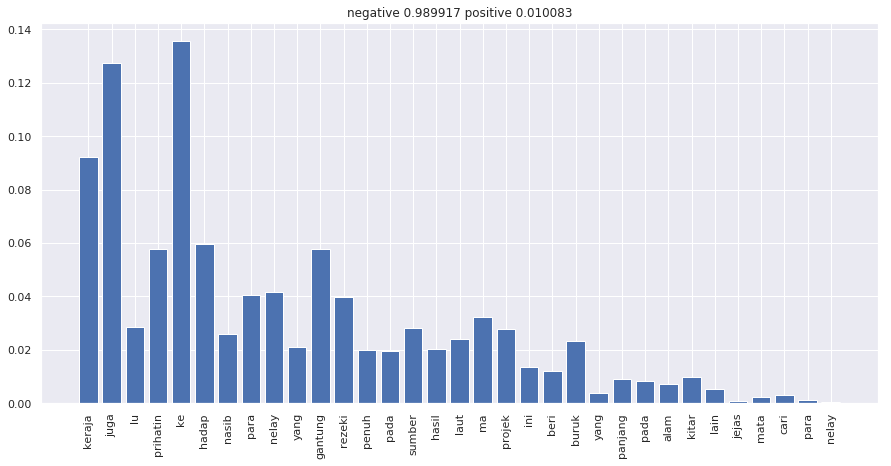

In [24]:
plt.figure(figsize = (15, 7))
labels = [word for word in text]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.title('negative %f positive %f' % (result[0][0,0], result[0][0,1]))
plt.show()

In [25]:
result[2]

array([[[0.89710563, 0.10289431],
        [0.9624851 , 0.03751488],
        [0.89275545, 0.10724449],
        [0.9584115 , 0.04158844],
        [0.99385417, 0.00614588],
        [0.9338556 , 0.06614447],
        [0.998459  , 0.00154108],
        [0.9196694 , 0.0803306 ],
        [0.95674217, 0.04325788],
        [0.9761288 , 0.0238712 ],
        [0.6641098 , 0.3358902 ],
        [0.33568034, 0.6643197 ],
        [0.95539314, 0.04460686],
        [0.8329092 , 0.16709076],
        [0.92663133, 0.07336862],
        [0.9719169 , 0.02808313],
        [0.66187865, 0.33812138],
        [0.9444652 , 0.05553479],
        [0.7917495 , 0.20825054],
        [0.45975384, 0.5402461 ],
        [0.8887881 , 0.11121183],
        [0.94811815, 0.05188191],
        [0.9534504 , 0.04654965],
        [0.9875206 , 0.01247945],
        [0.90523744, 0.09476253],
        [0.99308914, 0.00691085],
        [0.7476278 , 0.25237226],
        [0.9559297 , 0.0440703 ],
        [0.9214321 , 0.07856792],
        [0.857